In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 12.4.0


# Cross-Polarization and Co-Polarization RCS of a Corner Reflector

## Introduction

Radar Cross Section (RCS) is a crucial parameter in radar engineering, determining the detectability of an object by radar systems. It quantifies the power scattered by a target in the direction of the radar transmitter. Cross-polarization and co-polarization are two important aspects of RCS, delineating the polarization characteristics of radar waves and their interaction with the target.

**Co-Polarization RCS:**
Co-polarization refers to the scenario where the transmitted and received radar waves have the same polarization orientation. Co-polarization RCS measures the power scattered in the same polarization as the transmitted radar signal. In simpler terms, it assesses how much of the transmitted signal is reflected back in the same polarization as the original signal. Co-polarization RCS is particularly significant in radar applications where maintaining the polarization alignment between transmitter and receiver is crucial, such as in weather radar, ground-penetrating radar, and target detection.

**Cross-Polarization RCS:**
Cross-polarization, on the other hand, occurs when the transmitted and received radar waves have orthogonal polarization orientations. Cross-polarization RCS evaluates the power scattered in the polarization orthogonal to the transmitted signal. It assesses the level of signal scattering into a polarization different from the transmitted one. Cross-polarization RCS is pertinent in various radar applications, including radar imaging, target discrimination, and surveillance, as it provides additional information about the target's reflective properties and geometric structure.

Understanding both co-polarization and cross-polarization RCS is essential for radar system design, target detection, and signal processing. By analyzing the polarization characteristics of radar returns, engineers can optimize radar performance, enhance target detection capabilities, and mitigate interference effects caused by clutter and environmental conditions.

[`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) combines ray tracing and the Physical Optics (PO) approximation to simulate the Radar Cross Section (RCS) of a three-dimensional object using its model. In this example, we demonstrate how the [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) framework can be applied to derive the Cross-Polarization and Co-Polarization RCS of a corner reflector.

## 3D Model

[`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) leverages PyMeshLab for 3D model processing. This means that any 3D model format supported by PyMeshLab can seamlessly integrate with [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/).

Firstly, get the path of the model.


In [2]:
import pymeshlab
import numpy as np

target = {
    "model": "../models/cr.stl",
    "unit": "m",
    "location": (0, 0, 0),
}

_Plot the model_


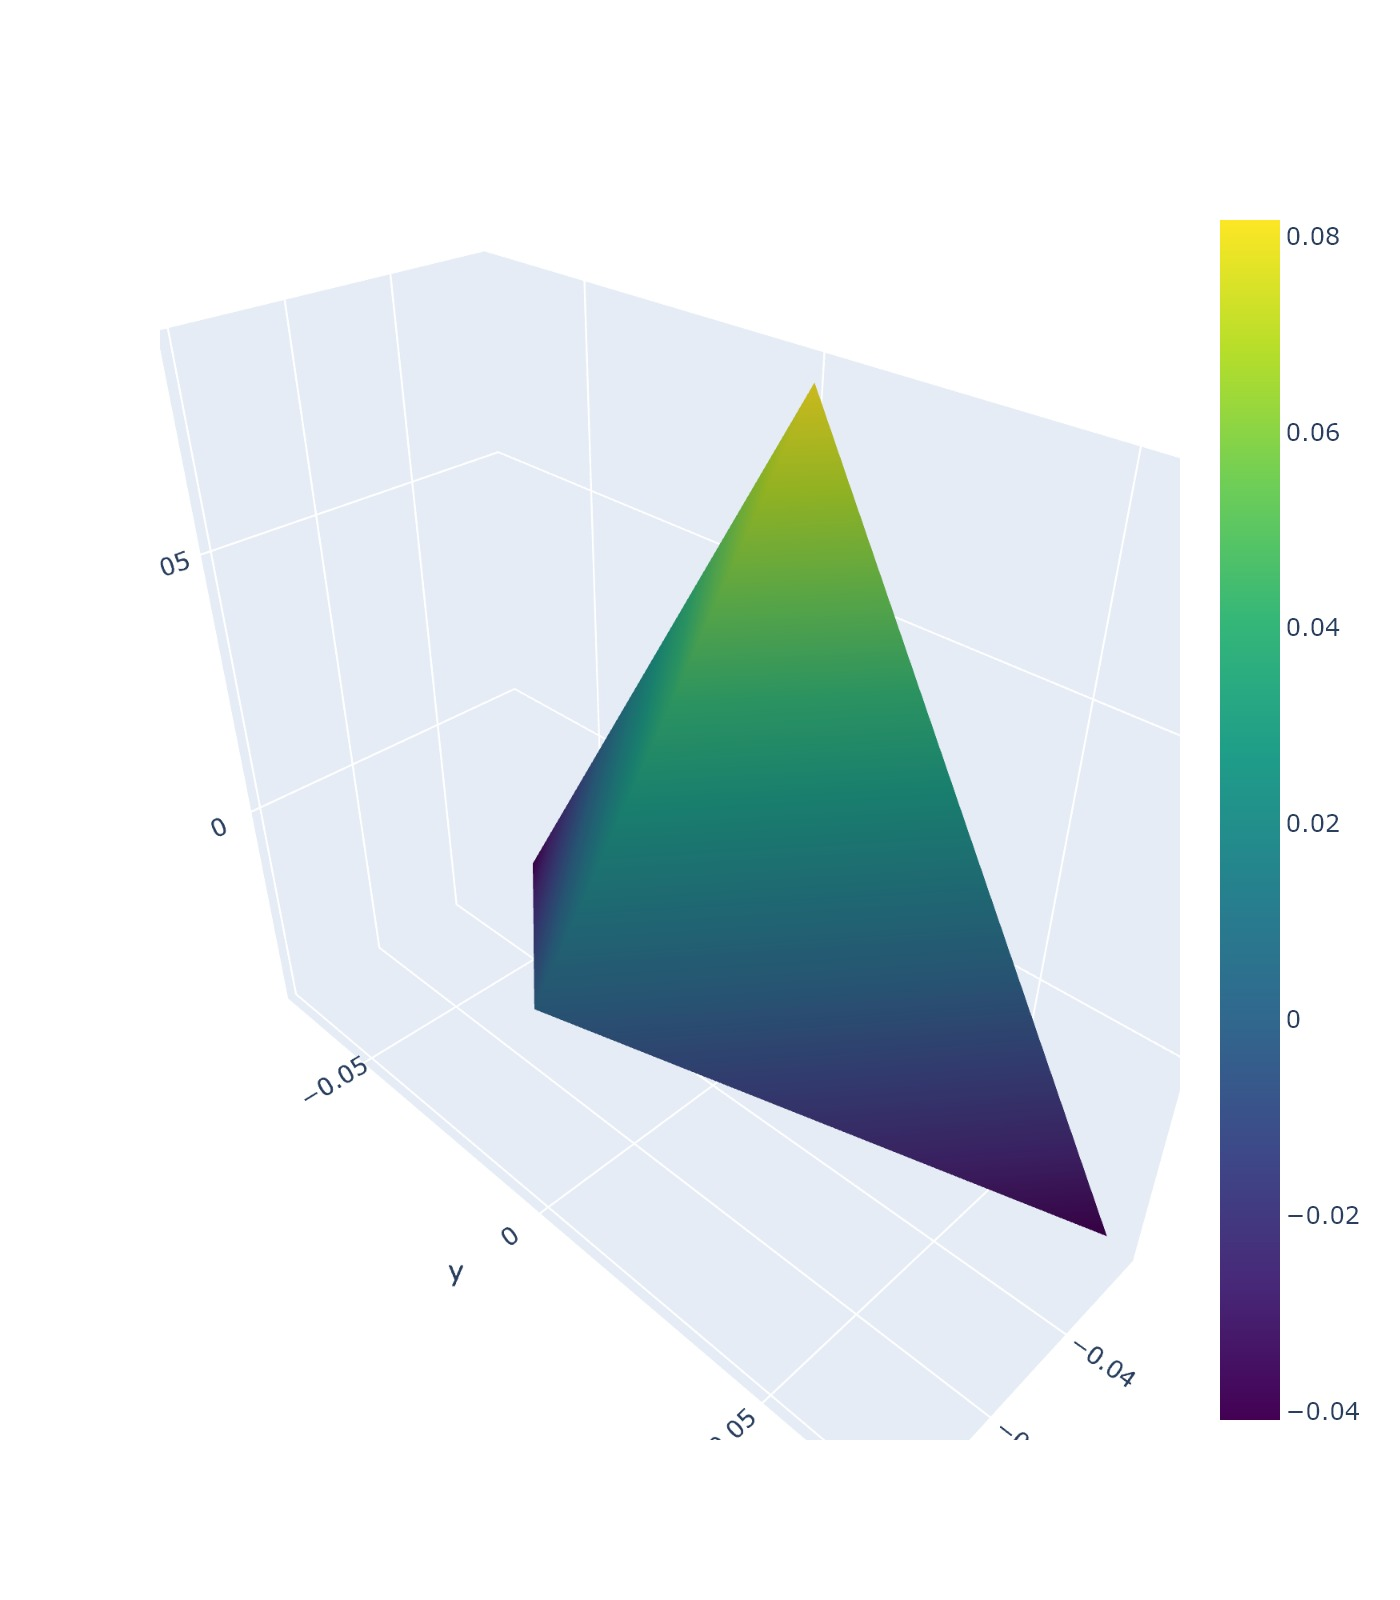

In [3]:
import plotly.graph_objs as go
from IPython.display import Image

ms = pymeshlab.MeshSet()
ms.load_new_mesh(target["model"])
t_mesh = ms.current_mesh()
v_matrix = np.array(t_mesh.vertex_matrix())
f_matrix = np.array(t_mesh.face_matrix())

fig = go.Figure()
fig.add_trace(
    go.Mesh3d(
        x=v_matrix[:, 0],
        y=v_matrix[:, 1],
        z=v_matrix[:, 2],
        i=f_matrix[:, 0],
        j=f_matrix[:, 1],
        k=f_matrix[:, 2],
        intensity=v_matrix[:, 2],
        colorscale="Viridis",
    )
)
fig["layout"]["scene"]["aspectmode"] = "data"
fig["layout"]["height"] = 800

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Simulate Cross-Polarization and Co-Polarization RCS


In [4]:
import time
from radarsimpy.rt import rcs_sbr

phi = np.arange(-90, 90, 0.5)
theta = 90
freq = 77e9
pol = [0, 0, 1]
pol_obs = [0, 1, 0]
density = 3

cross_rcs = np.zeros_like(phi)
co_rcs = np.zeros_like(phi)

tic = time.time()
for phi_idx, phi_ang in enumerate(phi):
    co_rcs[phi_idx] = 10 * np.log10(
        rcs_sbr([target], freq, phi_ang, theta, pol, density=density)
    )
    cross_rcs[phi_idx] = 10 * np.log10(
        rcs_sbr([target], freq, phi_ang, theta, pol, obs_pol=pol_obs, density=density)
    )
toc = time.time()

print("Exec time :" + str(toc - tic) + "s")

Exec time :60.84772849082947s


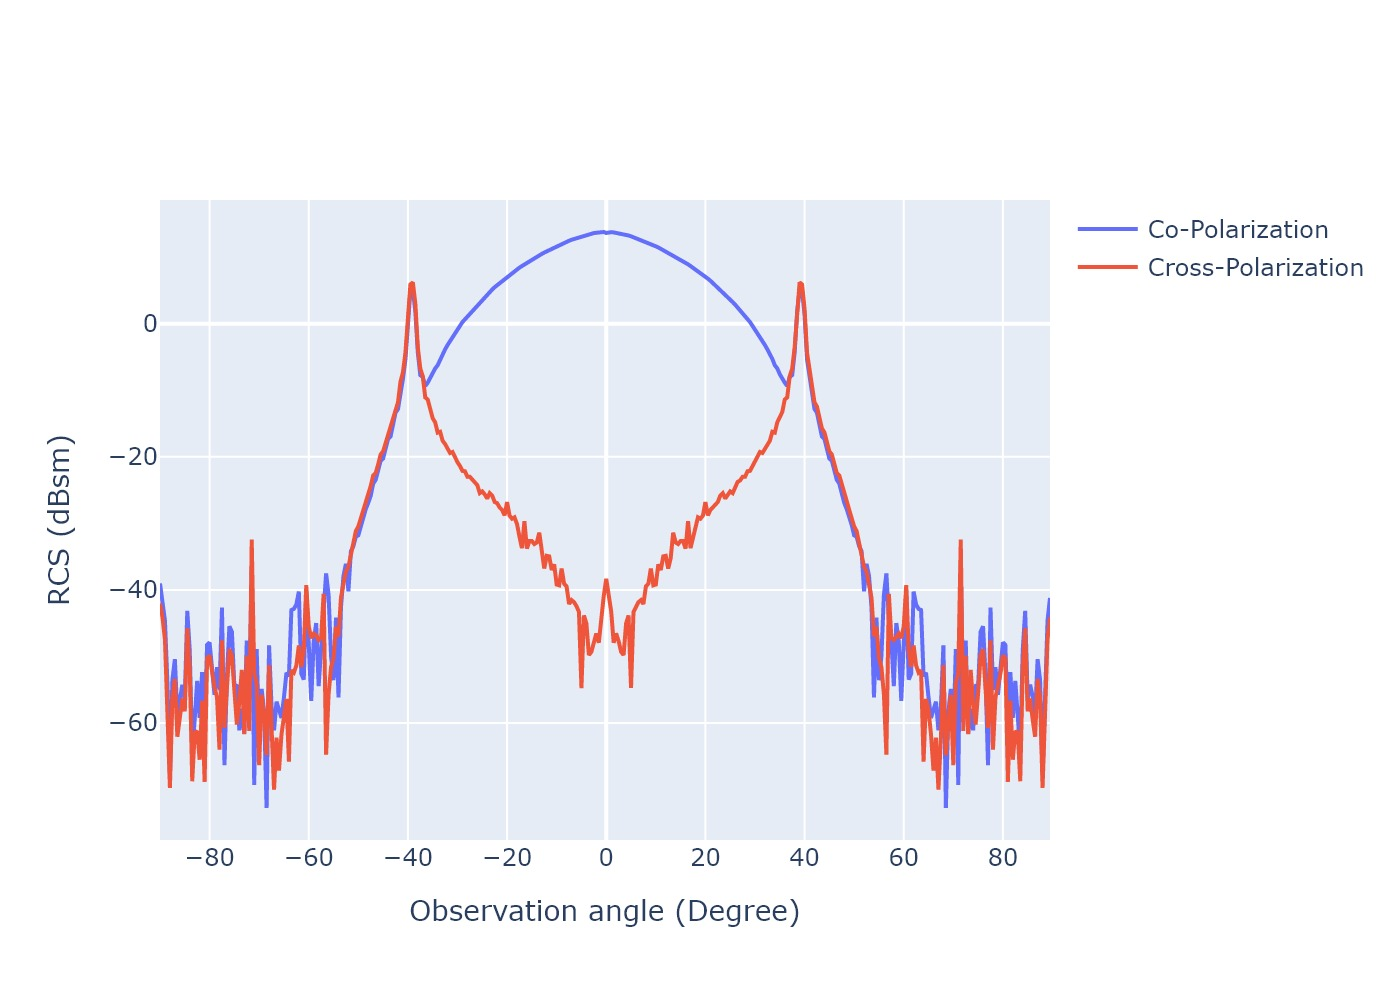

In [5]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=phi, y=co_rcs, name="Co-Polarization"))
fig.add_trace(go.Scatter(x=phi, y=cross_rcs, name="Cross-Polarization"))

fig.update_layout(
    yaxis=dict(title="RCS (dBsm)"),
    xaxis=dict(title="Observation angle (Degree)", dtick=20),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))